In [1]:
from collections import *
from numpy import *
import numpy as np
import csv
import sys
import json
import re
import nltk.data
import string
import sklearn.cluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xml.etree.ElementTree as ET
import sklearn.decomposition
from tsne import *
import sklearn.feature_extraction.text
csv.field_size_limit(sys.maxsize);

In [2]:
wv = defaultdict()
with open("data/glove.6B.300d.txt") as gloveFile:
    lines = gloveFile.read().split('\n')
    for line in lines:
        k = line.split(' ')
        wv[k[0]] = array(map(float, k[1:]))

In [3]:
def get_dependencies_as_list(filename):
    sentences = []
    tree = ET.parse(filename)
    root =  tree.getroot()
    sentences.extend(root.findall('.//sentence'))
    
    vocab = []
    sents = []
    sentenceList = []
    dependencies = []
    bets = ['bet', 'betting', 'bets', 'betting-shops', 'BETTING']
    for sentence in sentences:
        words = [w.text.lower() for w in sentence.findall('./tokens/token/word')]
        if "bet" in words or 'betting' in words or 'bets' in words or 'BETTING' in words or 'betting-shops' in words:
            sents.append(sentence.findall('.//word'))
            vocab.extend(sentence.findall('.//word'))
            sentenceList.append(" ".join(words))
            dep = sentence.findall('./dependencies/dep')
            results = [(d.find('governor').text.lower(),d.find('dependent').text.lower()) for d in dep]
            dependencies.append(unique([f if s in bets else s for f,s in results if f in bets or s in bets and f != "root"]))
    return sentenceList, dependencies, vocab, sents

In [4]:
# Returns two lists, one holding the sentence 
# and the other holding the classification
def get_file_for_nn(data_name, gold_name):
    f = open(data_name, 'r')
    lines = f.read().split('\n')
    data_sentences = []
    sent_concat = ""
    for i in range(0, len(lines)):
        if (lines[i].isdigit() == True):
            if (sent_concat):
                sent_concat = sent_concat.replace("<tag>", "")
                sent_concat = sent_concat.replace("</>", "")
                data_sentences.append(sent_concat.strip())
            sent_concat = ""
        elif (lines[i]):
            sent_concat += lines[i]
    f.close()
    
    classification = []
    class_list = []
    f2 = open(gold_name, 'r')
    for line in f2:
        line = line.split(":")[1].strip().split(" or ")
        for klass in line:
            if klass not in class_list:
                class_list.append(klass)  
        classification.append(line[0])
             
    for i in range(0, len(classification)):
        classification[i] = class_list.index(classification[i])
        
    f2.close()
    
    return data_sentences, classification, class_list

In [5]:
sentences1, classification, LABELS = get_file_for_nn("data/TEST/bet-n.eval", "data/GOLD/bet-n")

In [6]:
data_sentences, dependencies, vocab, sents = get_dependencies_as_list('data/PARSED/bet-n.eval.xml')
# USE THESE DATASTRUCTURES AND THE CLASSIFICATION ABOVE !!!!!!!! also note not indexed by 1 anymore

In [369]:
print len(sentences1)
print len(classification)
print len(data_sentences)
print len(dependencies)

270
271
271
271


In [7]:
def get_representation_dependency(data_sentences, dependencies, index):
    dependent = dependencies[index]
    means = [wv["bet"]] 
    keys = wv.keys()
    for word in dependent: 
        if word.lower() in keys:
            means.append(wv[word])
    means = np.mean(means, 0)      
    return means

In [67]:
matrix = []
for i in range(len(dependencies)):
    matrix.append(get_representation_dependency(data_sentences, dependencies, i))

In [386]:
first=50
clusterer = sklearn.cluster.KMeans(n_clusters=first, max_iter=500) #make max_iter higher later

In [387]:
matrix = np.array(matrix)
cluster_labels = clusterer.fit_predict(matrix)

In [389]:
# t = tsne(matrix,2,300,30)

In [ ]:
%matplotlib inline
plt.figure(figsize=(12,12))
colors = cm.spectral(cluster_labels.astype(float) / first)
plt.scatter(t[:, 0], t[:, 1], marker='.', s=120, lw=0, alpha=0.7, c=colors)
plt.show()

In [390]:
def getVocabSentenceMatrix(sentences, words):
    vocab = [w.text for w in words]
    arr = np.zeros((len(sentences), len(words)))
    for i, sentence in enumerate(sentences):
        for word in sentence:
            word_index = vocab.index(word.text)
            arr[i][word_index] = 1       
    return words, arr   

In [391]:
words, array = getVocabSentenceMatrix(sents, vocab)
communities = np.zeros((first, len(words)))
for i, sentences in enumerate(array):
    label = cluster_labels[i]
    communities[label] += array[i]
    
#TF-IDF
tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm='l2',smooth_idf=True)
communities = tfidf.fit_transform(communities).toarray()

# #SVD
svd = sklearn.decomposition.TruncatedSVD(n_components=first)
communities = svd.fit_transform(communities)

In [392]:
N_CLUSTERS = 30
clusterer = sklearn.cluster.KMeans(n_clusters=N_CLUSTERS, max_iter=300) #make max_iter higher later
n_cluster_labels = clusterer.fit_predict(communities)

In [316]:
t2 = tsne(communities,2,500,30)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  50 ...
Mean value of sigma:  0.284601551084
Iteration  10 : error is  11.1716724704
Iteration  20 : error is  12.529333854
Iteration  30 : error is  14.9505438225
Iteration  40 : error is  15.8483122707
Iteration  50 : error is  14.3443820503
Iteration  60 : error is  13.9741807098
Iteration  70 : error is  14.7441439252
Iteration  80 : error is  15.1346796444
Iteration  90 : error is  15.232798506
Iteration  100 : error is  18.562888069
Iteration  110 : error is  2.06785974931
Iteration  120 : error is  1.59155959026
Iteration  130 : error is  1.38978271138
Iteration  140 : error is  1.25752681105
Iteration  150 : error is  1.14448515676
Iteration  160 : error is  0.945127351251
Iteration  170 : error is  0.821363616316
Iteration  180 : error is  0.775697015256
Iteration  190 : error is  0.74512066954
Iteration  200 : error is  0.726274245306
Iteration  210 : error is  0.7105954171

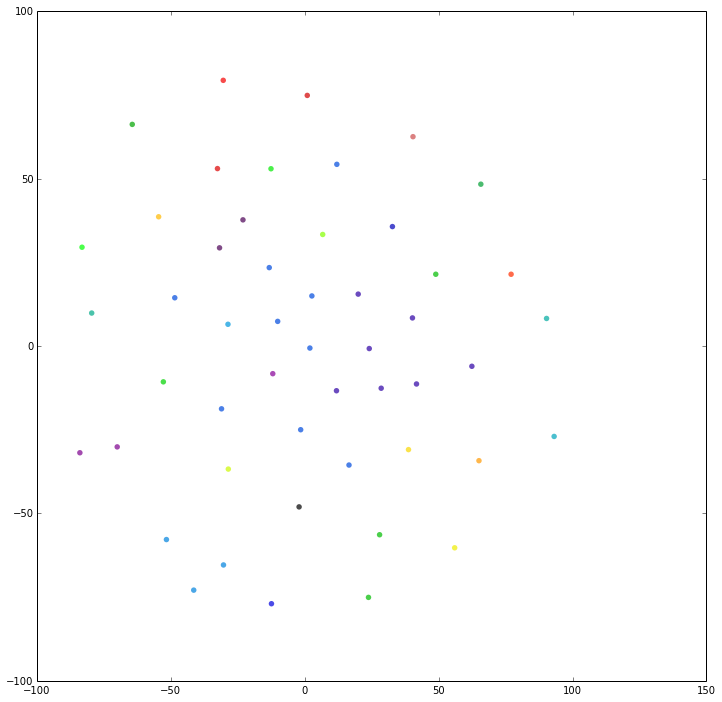

In [323]:
%matplotlib inline
plt.figure(figsize=(12,12))
colors = cm.spectral(n_cluster_labels.astype(float) / N_CLUSTERS)
plt.scatter(t2[:, 0], t2[:, 1], marker='.', s=120, lw=0, alpha=0.7, c=colors)
plt.show()

In [393]:
def all_clusters_from_original(sentences, index):
    sent = []
    for d, label in zip(sentences, cluster_labels):
        if label == index:
            sent.append(d)
    return sent
            
# first: cluster_labels, second: n_cluster_labels
clusters = defaultdict()
for i, label in enumerate(n_cluster_labels):
    clusters[label] = all_clusters_from_original(sentences1, i)

In [394]:
n_words, n_array = getVocabSentenceMatrix(sents, vocab)
n_communities = np.zeros((30, len(words)))
for cluster in clusters:
    for sent in clusters[cluster]:
        index = sentences1.index(sent)
        n_communities[cluster] += n_array[index]

In [406]:
# tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm='l2',smooth_idf=True)
# n_communities = tfidf.fit_transform(n_communities).toarray()
N_CLUSTERS = 16
clusterer = sklearn.cluster.KMeans(n_clusters=N_CLUSTERS, max_iter=300) #make max_iter higher later
nn_cluster_labels = clusterer.fit_predict(n_communities)

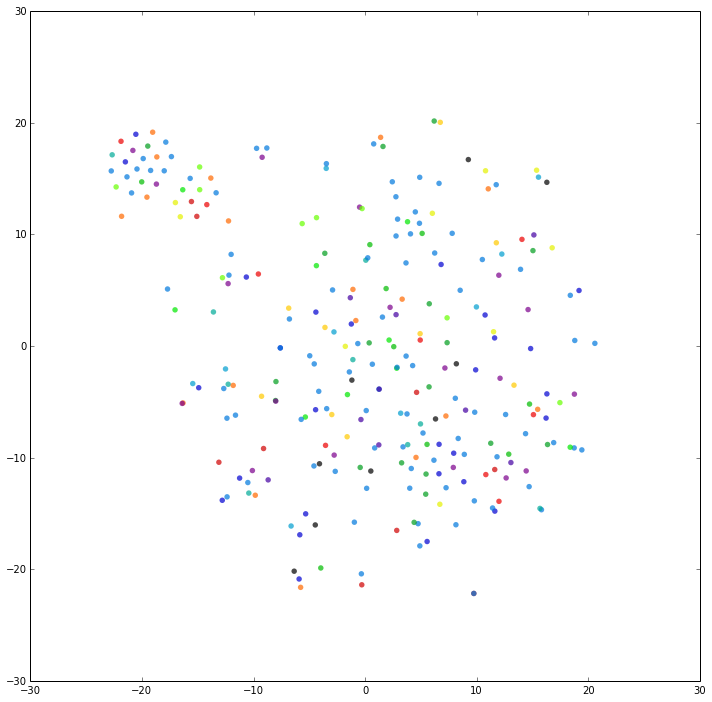

In [396]:
plt.figure(figsize=(12,12))
colors = cm.spectral(nn_cluster_labels.astype(float) / N_CLUSTERS)
plt.scatter(t[:, 0], t[:, 1], marker='.', s=120, lw=0, alpha=0.7, c=colors)
plt.show()

In [397]:
klass = []
# nn_cluster_labels (16), n_cluster_labels (36), cluster_labels (80)

d1 = defaultdict()
for idx,l in enumerate(cluster_labels):
    if l in d1:
        d1[l].append(idx)
    else:
        d1[l] = [idx]

In [398]:
d2 = defaultdict()
for idx,l in enumerate(n_cluster_labels):
    if l in d2:
        d2[l].extend(d1[idx])
    else:
        d2[l] = d1[idx]

In [399]:
d3 = defaultdict()
for idx,l in enumerate(nn_cluster_labels):
    if l in d3:
        d3[l].extend(d2[idx])
    else:
        d3[l] = d2[idx]

In [400]:
klasses = defaultdict() 
for key in d3:
    for sent in d3[key]:
        klasses[sent] = key

In [401]:
klasses_list = []
for key in klasses:
    klasses_list.append(klasses[key])
print klasses_list

[4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 7, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 13, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 2, 7, 4, 6, 13, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 14, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 11, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 10, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 12, 4, 1, 4, 4, 4, 4, 4, 12, 4, 0, 4, 4, 4, 4, 4, 4, 4, 14, 4, 4, 4, 4]


<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


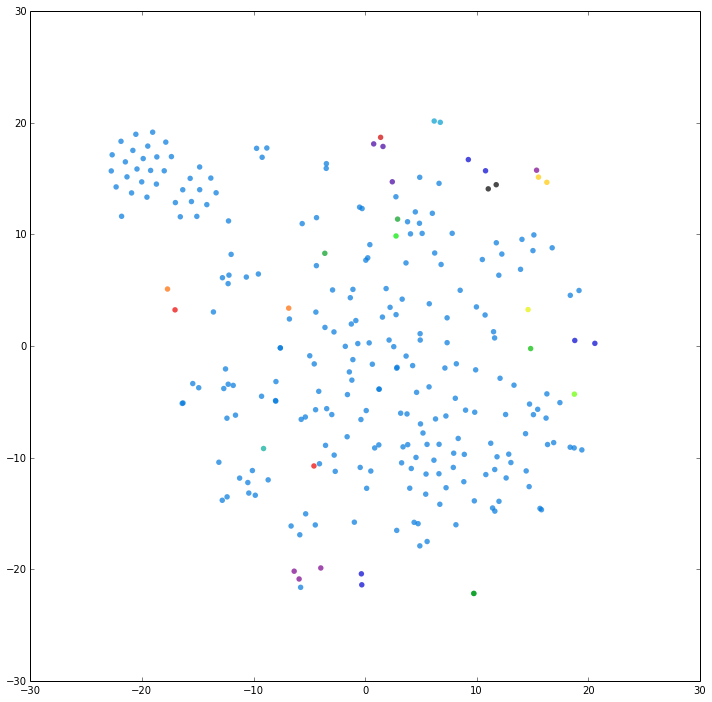

In [402]:
print type(cluster_labels)
klasses_list = np.array(klasses_list)
print type(klasses_list)
%matplotlib inline
plt.figure(figsize=(12,12))
colors = cm.spectral(klasses_list.astype(float) / 16)
plt.scatter(t[:, 0], t[:, 1], marker='.', s=120, lw=0, alpha=0.7, c=colors)
plt.show()

In [403]:
print len(classification)
print len(klasses_list)

271
271


In [404]:
def evaluate(target, predicted, metric_type):
    # 0 -> false, 1 -> true
    if metric_type == "pairwise":
        predict = []
        true = []
        for i in range(0, len(predicted)):
            for j in range(0, len(predicted)):
                if i != j:
                    if predicted[i] == predicted[j]:
                        predict.append(1)
                    else:
                        predict.append(0) 
                        
                    if target[i] == target[j]:
                        true.append(1)
                    else:
                        true.append(0)
        
        scores = {"Precision" : metrics.precision_score(true, predict)
                  , "Recall" : metrics.recall_score(true, predict)}
        scores["F-1"] = (2 * scores["Precision"] * scores["Recall"]) / (scores["Precision"] + scores["Recall"])
        return scores
        
    elif metric_type == "b3":
        scores = {"Precision" : 0., "Recall" : 0.}
        for i in range(0, len(predicted)):
            predict = []
            true = []
            for j in range(0, len(predicted)):
                if predicted[i] == predicted[j]:
                    predict.append(1)
                else:
                    predict.append(0)   
            
                if target[i] == target[j]:
                    true.append(1)
                else:
                    true.append(0)
                    
            scores["Precision"] += metrics.precision_score(true, predict)
            scores["Recall"] += metrics.recall_score(true, predict)
        
        scores["Precision"] /= len(predicted)
        scores["Recall"] /= len(predicted)
        scores["F-1"] = (2 * scores["Precision"] * scores["Recall"]) / (scores["Precision"] + scores["Recall"])             
        return scores
    
    else: 
        return None

In [405]:
from sklearn import metrics
print "b3"
print evaluate(classification, klasses_list, "b3")
print "pairwise"
print evaluate(classification, klasses_list, "pairwise")

b3
{'Recall': 0.81375724192024623, 'Precision': 0.20986697261930581, 'F-1': 0.33367864179660689}
pairwise
{'Recall': 0.75782789577403109, 'Precision': 0.12256533748849069, 'F-1': 0.21100442005791803}
